<br>

# 다양한 Augmentation 적용
---

<br>

<br>

## 데이터 준비 <br><br>

TensorFlow Datasets 의 stanford_dogs 데이터셋 사용 <br><br>

120 종류의 개 <br>
총 20580 장 \[12000 장 학습셋, 8580 장 평가셋\]

<br>

In [122]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [123]:
# GPU 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [124]:
# 데이터 다운로드시 10분 이상 소요될 수 있음

import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

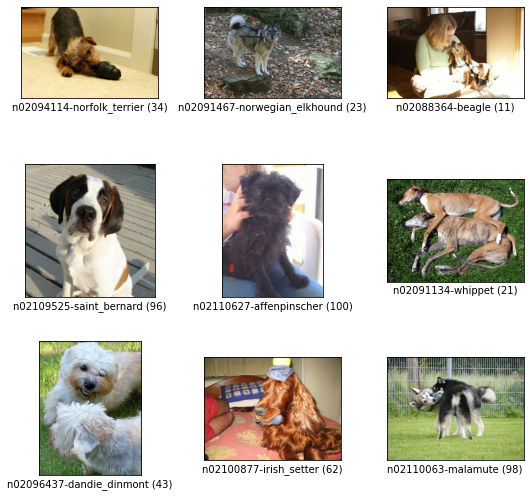

In [125]:
# 샘플 확인

fig = tfds.show_examples(ds_train, ds_info)

<br>

## 데이터 전처리 <br><br>


### Normalize 와 Resize 적용 <br><br>


- Normalize : 0~1 사이 값으로 변환
- Resize : (224,224) 사이즈로 변환

<br>

In [126]:
# Normalize 와 Resize 전처리 함수 작성

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

<br>

### Augmentation 적용 <br><br>

주의. <br>
데이터 shuffle 이나 Augmentation 처리는 학습셋에서만 적용해야 합니다. <br>
(테스트셋에는 적용하면 안됩니다!) <br><br>

Augmentation 을 통해 데이터를 가공하는 메인함수에서 <br>
학습셋에 적용하는 과정과 테스트셋에 적용하는 과정을 분기하면 좋습니다. <br><br>

CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, <br>
미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용 <br><br>

참고. <br>
텐서플로우 데이터셋에 map() 적용하기 <br>
[tf.data.Datasets.map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)

<br>

In [127]:
# Cutmix Augmentation 나 Mixup Augmentation 적용하는 경우에는 

def onehot(image,label):
    CLASSES = 120
    return image,tf.one_hot(label,CLASSES)

In [128]:
# 데이터셋을 전처리 함수와 augmentation 함수를 적용하여 가공하는 메인함수 작성

# is_test 과 with_aug 인자로 학습셋과 테스트셋에 따라 분기
# with_cutmix 인자로 cutmix augmentation 의 경우의 데이터 생성

"""
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):

    # 데이터 전처리 적용
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )

    # 일반 augmentation 적용하는 경우
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )

    # cutmix augmentation 적용하는 경우
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    # mixup augmentation 적용하는 경우
    elif not is_test and with_aug:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    # cutmix 와 mixup 제외한 나머지 학습셋에 one-hot 인코딩 적용(?)
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    # 평가셋 제외한 모든 학습셋에 대해 셔플 적용
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds
"""

In [145]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

<br>

## Augmentation 종류별 함수 작성

<br>

<br>

### Augmentation 1 : tf.image API 사용 <br><br>

텐서플로우에서 제공하는 API 중, <br>
tf.image 아래에 있는 여러 Random Augmentation API 들을 사용할 수 있습니다. <br><br>

- random_brightness() <br>
- random_contrast() <br>
- random_crop() <br>
- random_flip_left_right() <br>
- random_flip_up_down() <br>
- random_hue() <br>
- random_jpeg_quality() <br>
- random_saturation() <br>

<br>


In [146]:
# random_flip_left_right() 과 random_brightness() 적용

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [147]:
# central_crop() 적용 후 resize

def augment2(image,label):

    # 50% 확률로 이미지 가운데 부분을 crop
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    # crop한 이미지를 원본 사이즈로 resize
    image = tf.image.resize(image, INPUT_SHAPE) 
    
    return image, label

<br>

### Augmentation 2 : Cutmix Augmentation 사용 <br><br>


- 두 이미지 섞기 1. Cutmix Augmentation <br>

    일정 영역을 잘라서 붙여주는 방식 <br>
    네이버 클로바에서 제공하는 API <br>
    참고. [paper](https://arxiv.org/pdf/1905.04899.pdf) <br><br>
    
    캐글 그랜드마스터 Chris Duottes 가 구현한 것 참고 <br>
    참고. [kaggle](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)

<br>

<br>

#### 이미지 섞기 <br><br>


첫 번째 이미지를 바탕으로 하고, <br>
두 번째 이미지를 그 위에 삽입 <br><br>

삽입될 바운딩 박스의 위치 결정 필요

<br>

In [148]:
# 삽입될 바운딩 박스의 위치를 결정하는 함수

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

In [149]:
# 바탕이미지에서 바운딩 박스 경계로 바깥과 안쪽에 서로 다른 이미지 넣는 함수 구현

# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]

    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

<br>

#### 라벨 섞기 <br><br>

앞에서 이미지를 cutmix 를 통해 섞은만큼, <br>
라벨도 같은 비율로 섞어줘야 합니다. <br><br>

Cutmix 에서는 면적에 비례하게 라벨 섞기

<br>

In [150]:
# [바탕이미지:바운딩 박스] 와 같은 비율로 라벨을 섞어주는 함수 구현

# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

<br>

#### 배치 단위 cutmix() 구현 <br><br>

위에서 구현한 mix_2_images() 와 mix_2_label() 활용하여 <br>
배치 단위의 cutmix() 함수 구현

<br>

In [151]:
# 배치 단위의 cutmix() 함수 구현

def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

<br>

### Augmentation 3 : Mixup Augmentation 사용 <br><br>

- 두 이미지 섞기 2. mixup Augmentation <br>

    두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식 <br>
    (구현의 측면에서 보면 CutMix 보다 구현이 간단) <br>
    참고. [paper](https://arxiv.org/abs/1710.09412)

<br>

<br>

#### 이미지 와 라벨 섞기 <br><br>

두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, <br>
해당 비율값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 됩니다.

<br>

In [152]:
# 일정 비율에 대해 두 쌍의 이미지와 그 라벨 섞기

# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

<br>

### 배치 단위 mixup() 구현 <br><br>

위에서 구현한 mixup_2_images() 활용하여 <br>
배치 단위의 mixup() 함수 구현

<br>

In [153]:
# 배치 단위의 mixup() 함수 구현

def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

<br>



<br>

<br>

## 모델 작성 : ResNet50 <br><br>

tensorflow.keras 에서 imagenet 으로 학습시켜 놓은 ResNet50 모델 불러 사용 <br><br>

- include_top : 마지막 FC(fully connected layer) 를 포함할지 여부 <br>

    이를통해 앞의 특성추출부 (feature extractor) 만 불러오고, <br>
    뒷 부분 FC 는 알맞게 수정하여 붙일 수 있습니다. <br>

    ex. 서로 다른 클래스를 분류하는 문제의 경우

<br>

In [154]:
# 모델 최종 출력단을 위한 클래스 개수

num_classes = ds_info.features["label"].num_classes

<br>

### No augmentation ResNet-50 모델

<br>

In [155]:
# Augmentation 적용하지 않은 데이터셋 학습용 ResNet50 모델 불러오기

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

<br>

### basic augmentation ResNet-50 모델

<br>

In [156]:
# 기본 Augmentation 적용한 데이터셋 학습용 ResNet50 모델 불러오기

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

<br>

### cutmix augmentation ResNet-50 모델

<br>

In [157]:
# 기본 Augmentation 적용한 데이터셋 학습용 ResNet50 모델 불러오기

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

<br>

### mixup augmentation ResNet-50 모델

<br>

In [158]:
# 기본 Augmentation 적용한 데이터셋 학습용 ResNet50 모델 불러오기

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

<br>

## 학습, 평가용 데이터셋 준비 <br><br>

- 학습셋 <br>
    ds_train_no_aug : 어그멘테이션 적용 안한 학습셋 <br>
    ds_train_aug : 기본 어그멘테이션 적용한 학습셋 <br>
    ds_train_cutmix : cutmix 어그멘테이션 적용한 학습셋 <br>
    ds_train_mixup : mixup 어그멘테이션 적용한 학습셋 <br><br>

- 평가셋 <br>
    ds_test : 어그멘테이션 적용 안한 평가셋

<br>

In [159]:
# 데이터셋 준비

# 텐서플로우 데이터셋에서 데이터 로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [160]:
# 학습셋 준비
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)

# 평가셋 준비
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

NameError: in user code:

    <ipython-input-151-cba6fe33448c>:15 cutmix  *
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))
    <ipython-input-150-d0c5a86e8e5a>:5 mix_2_label  *
        image_size_x = image_a.shape[1]

    NameError: name 'image_a' is not defined


<br>

## 모델 학습 <br><br>


### 학습단계에서 loss function

- __sparse_categorical_crossentropy()__ 사용 <br>

     No augmentation ResNet50 모델 <br>
     Basic augmentation ResNet50 모델 <br><br>

- __categorical_crossentropy()__ 사용 <br>

     CutMix augmentation ResNet50 모델 <br>
     Mixip augmentation ResNet50 모델 <br><br>

     cutmix(), mixup() 을 구현하면서 label 의 mix 때문에 <br>
     더이상 label 이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문 <br><br><br>



참고. <br>
아래 학습은 EPOCH=20으로 진행시 GPU 기반으로 3~4시간 가량의 시간이 소요됩니다. Augmentation 적용 효과를 명확히 검증하기 위해서는 최소 이정도의 학습이 진행되어야 하지만, 원활한 학습 진행을 위해서 EPOCH=3 정도로 진행해 보기를 권합니다. 하지만 실제 프로젝트 단계에서는 꼭 충분한 학습이 진행되어야 합니다.

<br>

In [ ]:
# 학습 하이퍼파라미터 설정

#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3
tf.random.set_seed(2020)

In [13]:
# No Augmentation 모델 학습

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3
750/750 [==============================] - 128s 171ms/step - loss: 2.2163 - accuracy: 0.4477 - val_loss: 3.0054 - val_accuracy: 0.2649
Epoch 2/3
750/750 [==============================] - 129s 172ms/step - loss: 0.7661 - accuracy: 0.7854 - val_loss: 1.2922 - val_accuracy: 0.6250
Epoch 3/3
750/750 [==============================] - 129s 173ms/step - loss: 0.2881 - accuracy: 0.9338 - val_loss: 0.9854 - val_accuracy: 0.7099
Epoch 1/3
750/750 [==============================] - 131s 174ms/step - loss: 2.2421 - accuracy: 0.4358 - val_loss: 3.0138 - val_accuracy: 0.2641
Epoch 2/3
750/750 [==============================] - 130s 173ms/step - loss: 0.9537 - accuracy: 0.7204 - val_loss: 1.2739 - val_accuracy: 0.6312
Epoch 3/3
750/750 [==============================] - 130s 174ms/step - loss: 0.5463 - accuracy: 0.8462 - val_loss: 1.1826 - val_accuracy: 0.6589


In [ ]:
# Basic Augmentation 적용한 모델 학습

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
# Cutmix Augmentation 적용한 모델 학습

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
# Mixup Augmentation 적용한 모델 학습

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = mixup_resnet50.fit(
    ds_train_mixup, # mixup augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

<br>

### 훈련 과정 시각화

<br>

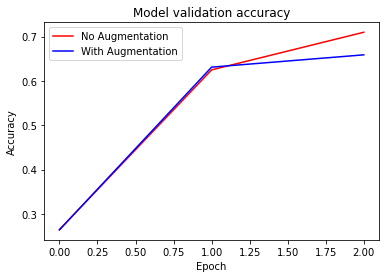

In [14]:
# 훈련 과정 시각화

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

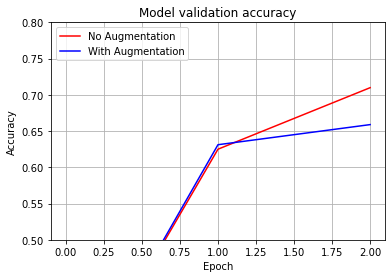

In [15]:
# 확대 시각화

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

<br>

## 결과 분석 <br><br>

분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석 <br><br>

참고로, EPOCH=20으로 수행해 본 두 모델의 훈련 과정 시각화한 내용은 아래 그림과 같습니다. Aumentation을 적용한 경우가 보다 천천히 학습되지만, EPOCH 10을 전후해서 aug_resnet50의 accuracy가 더 높게 형성되는 것을 확인할 수 있습니다.

<br>